---
title: "Generative AI: GANs"
description: "Part 4: Generative Adversarial Networks"
date: "2024-04-10"
# image: "deep_learning_model.png"
categories: [AI, Engineering, GenerativeAI, GAN]
format:
  html:
    code-fold: true
---

# GANs

Notes on Generative Adversarial Networks (GANs).

::: {.callout-tip title="Story Time"}
Imagine a forger trying to forge £20 notes and the popo trying to stop them.

The popo learn to spot the fakes.
But then the forger learns to improve their forging skills to make better fakes.

This goes back and forth. With each iteration, the forger keeps getting better but then the popo learn to spot these more sophisticated fakes.

The results in a forger (generator) learning to create convincing fakes and the popo (discriminator) learning to spot fakes.
:::


## 1. GANs
The idea of GANs is that we can train two competing models:

- The **generator** tries to convert random noise into convincing observations.
- The **discriminator** tries to predict whether an observation came from the original training dataset or is a "fake".

We initialise both as random models; the generator outputs noise and the discriminator predicts randomly.
We then alternate the training of the two networks so that the generator gets incrementally better at fooling the discriminator, then the discriminator gets incrementally better at spotting fakes.


```{mermaid}
flowchart LR

  A([Random noise]) --> B[Generator] --> C([Generated image]) 

  D([Image]) --> E[Discriminator] --> F([Prediction of realness probability])
```



## 2. Building a Deep Convolutional GAN (DCGAN)
We will implement a GAN to generate [pictures of bricks](https://www.kaggle.com/datasets/joosthazelzet/lego-brick-images).

### 2.1. Load and pre-process the data
Load image data of lego bricks. We will train a model that can generate novel lego brick images.


#### tanh vs sigmoid activation
The original data is scaled from [0, 255].

Often we will rescale this to [0, 1] so that we can use sigmoid activation functions.

In this case we will scale to [-1, 1] so that we can use tanh activation functions, which tend to give stronger gradients than sigmoid.


In [11]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import (
    layers,
    models,
    callbacks,
    losses,
    utils,
    metrics,
    optimizers,
)


def sample_batch(dataset):
    batch = dataset.take(1).get_single_element()
    if isinstance(batch, tuple):
        batch = batch[0]
    return batch.numpy()


def display_images(
    images, n=10, size=(20, 3), cmap="gray_r", as_type="float32", save_to=None
):
    """Displays n random images from each one of the supplied arrays."""
    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images = (images + 1.0) / 2.0

    plt.figure(figsize=size)
    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].astype(as_type), cmap=cmap)
        plt.axis("off")

    if save_to:
        plt.savefig(save_to)
        print(f"\nSaved to {save_to}")

    plt.show()

Model and data parameters:

In [14]:
DATA_DIR = Path("/Users/gurpreetjohl/workspace/datasets/lego-brick-images")

IMAGE_SIZE = 64
CHANNELS = 1
BATCH_SIZE = 128
Z_DIM = 100
EPOCHS = 100
LOAD_MODEL = False
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.999
LEARNING_RATE = 0.0002
NOISE_PARAM = 0.1

Load and pre-process the training data:

In [17]:
def preprocess(img):
    """Normalize and reshape the images."""
    img = (tf.cast(img, "float32") - 127.5) / 127.5
    return img


training_data = utils.image_dataset_from_directory(
    DATA_DIR / "dataset",
    labels=None,
    color_mode="grayscale",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    interpolation="bilinear",
)
train = training_data.map(lambda x: preprocess(x))

Found 40000 files belonging to 1 classes.


Some sample input images:

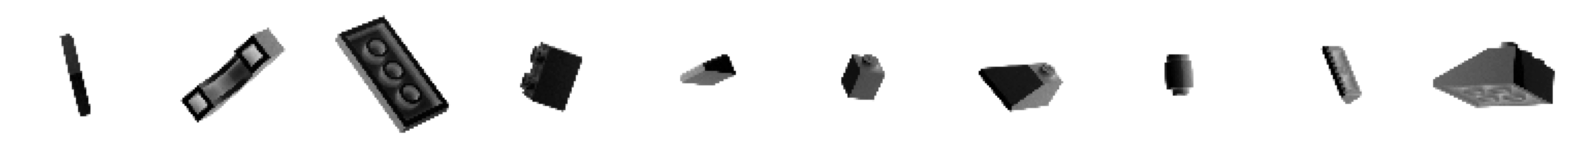

In [20]:
display_images(sample_batch(train))

### 2.2. Build the Discriminator

The goal of the discriminator is to predict whether an image is real or fake. 

This is a supervised binary classification problem, so we can use CNN architecture with a single output node. We stack `Conv2D` layers with `BatchNormalization`, `LeakyReLU` and `Dropout` layers sandwiched between.

In [22]:
discriminator_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

x = layers.Conv2D(64, kernel_size=4, strides=2, padding="same", use_bias=False)(discriminator_input)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(128, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(256, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(512, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(1, kernel_size=4, strides=1, padding="valid", use_bias=False, activation="sigmoid")(x)
discriminator_output = layers.Flatten()(x)  # The shape is already 1x1 so no need for a Dense layer after this

discriminator = models.Model(discriminator_input, discriminator_output)
discriminator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 64)        1024      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 dropout_4 (Dropout)         (None, 32, 32, 64)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 128)       131072    
                                                                 
 batch_normalization_3 (Bat  (None, 16, 16, 128)       512       
 chNormalization)                                                
                                                           

### 2.3. Build the Generator

The purpose of the generator is to turn random noise into convincing images.

The input is a vector sampled from a multivariate Normal distribution, and the output is an image of the same size as the training data.

The discriminator-generator relationship in a GAN is similar to that of the encoder-decoder relations in a VAE.

The architecture of the discriminator is similar to the discriminator but *in reverse* (like a decoder). We pass stack `Conv2DTranspose` layers with `BatchNormalization` and `LeakyReLU` layers sandwiched in between.

#### Conv2DTranspose

We use `Conv2DTranspose` layers to scale the image size up. 

An alternative would be to use stacks of `Upsampling2D` and `Conv2D` layers, i.e. the following serves the same purpose as a `Conv2DTranspose` layer:
```python
x = layers.Upsampling2D(size=2)(x)
x = layers.Conv2D(256, kernel_size=4, strides=1, padding="same")(x)
```

The `Upsampling2D` layer simply repeats each row and column to double its size, then Conv2D applies a convolution.

The idea is similar with `Conv2DTranspose`, but the extra rows and columns are *filled with zeros* rather than repeated existing values.

`Conv2DTranspose` layers can result in checkerboard pattern artifacts. Both options are used in practice, so it is often helpful to experiment and see which gives better results.

In [23]:
generator_input = layers.Input(shape=(Z_DIM,))

x = layers.Reshape((1, 1, Z_DIM))(generator_input)  # Reshape the input vector so we can apply conv transpose operations to it

x = layers.Conv2DTranspose(512, kernel_size=4, strides=1, padding="valid", use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)

generator_output = layers.Conv2DTranspose(
    CHANNELS,
    kernel_size=4,
    strides=2,
    padding="same",
    use_bias=False,
    activation="tanh",
)(x)

generator = models.Model(generator_input, generator_output)
generator.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100)]             0         
                                                                 
 reshape (Reshape)           (None, 1, 1, 100)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 4, 4, 512)         819200    
 anspose)                                                        
                                                                 
 batch_normalization_6 (Bat  (None, 4, 4, 512)         2048      
 chNormalization)                                                
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 8, 8, 256)         2097

### 2.4. Train the GAN

We alternate between training the discriminator and generator. They are not trained simultaneously. We want the generated images to be predicted close to 1 because the generator is good, not because the discriminator is weak.

For the discriminator, we create a training set where some images are real images from the training data and some are outputs from the generator. This is then a supervised binary classification problem.

For the generator, we want a way of scoring each generated image on its realness so that we can optimise this. The discriminator provides exactly this. We pass the generated images through the discriminator to get probabilities. The generator wants to fool the discriminator, so ideally this would be a vector of 1s. So the loss function is the binary crossentropy between these probabilities and a vector of 1s.


In [24]:
class DCGAN(models.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(DCGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer):
        super(DCGAN, self).compile()
        self.loss_fn = losses.BinaryCrossentropy()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_metric = metrics.Mean(name="d_loss")
        self.d_real_acc_metric = metrics.BinaryAccuracy(name="d_real_acc")
        self.d_fake_acc_metric = metrics.BinaryAccuracy(name="d_fake_acc")
        self.d_acc_metric = metrics.BinaryAccuracy(name="d_acc")
        self.g_loss_metric = metrics.Mean(name="g_loss")
        self.g_acc_metric = metrics.BinaryAccuracy(name="g_acc")

    @property
    def metrics(self):
        return [
            self.d_loss_metric,
            self.d_real_acc_metric,
            self.d_fake_acc_metric,
            self.d_acc_metric,
            self.g_loss_metric,
            self.g_acc_metric,
        ]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )

        # Train the discriminator on fake images
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(
                random_latent_vectors, training=True
            )

            # Evaluate the discriminator on the real and fake images
            real_predictions = self.discriminator(real_images, training=True)
            fake_predictions = self.discriminator(generated_images, training=True)

            real_labels = tf.ones_like(real_predictions)
            real_noisy_labels = real_labels + NOISE_PARAM * tf.random.uniform(
                tf.shape(real_predictions)
            )
            fake_labels = tf.zeros_like(fake_predictions)
            fake_noisy_labels = fake_labels - NOISE_PARAM * tf.random.uniform(
                tf.shape(fake_predictions)
            )

            # Calculate the losses
            d_real_loss = self.loss_fn(real_noisy_labels, real_predictions)
            d_fake_loss = self.loss_fn(fake_noisy_labels, fake_predictions)
            d_loss = (d_real_loss + d_fake_loss) / 2.0

            g_loss = self.loss_fn(real_labels, fake_predictions)

        # Update gradients
        gradients_of_discriminator = disc_tape.gradient(
            d_loss, self.discriminator.trainable_variables
        )
        gradients_of_generator = gen_tape.gradient(
            g_loss, self.generator.trainable_variables
        )

        self.d_optimizer.apply_gradients(
            zip(gradients_of_discriminator, discriminator.trainable_variables)
        )
        self.g_optimizer.apply_gradients(
            zip(gradients_of_generator, generator.trainable_variables)
        )

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.d_real_acc_metric.update_state(real_labels, real_predictions)
        self.d_fake_acc_metric.update_state(fake_labels, fake_predictions)
        self.d_acc_metric.update_state(
            [real_labels, fake_labels], [real_predictions, fake_predictions]
        )
        self.g_loss_metric.update_state(g_loss)
        self.g_acc_metric.update_state(real_labels, fake_predictions)

        return {m.name: m.result() for m in self.metrics}

In [25]:
# Create a DCGAN
dcgan = DCGAN(
    discriminator=discriminator, generator=generator, latent_dim=Z_DIM
)

In [33]:
dcgan.compile(
    d_optimizer=optimizers.legacy.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
    g_optimizer=optimizers.legacy.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
)
dcgan.fit(train,  epochs=EPOCHS)

Epoch 1/100


313/313 [==============================] - 459s 1s/step - d_loss: 0.0252 - d_real_acc: 0.9011 - d_fake_acc: 0.9013 - d_acc: 0.9012 - g_loss: 5.3464 - g_acc: 0.0987
Epoch 2/100
313/313 [==============================] - 459s 1s/step - d_loss: 0.0454 - d_real_acc: 0.8986 - d_fake_acc: 0.8997 - d_acc: 0.8992 - g_loss: 5.2642 - g_acc: 0.1002
Epoch 3/100
313/313 [==============================] - 458s 1s/step - d_loss: 0.0556 - d_real_acc: 0.8958 - d_fake_acc: 0.8975 - d_acc: 0.8967 - g_loss: 4.9679 - g_acc: 0.1025
Epoch 4/100
313/313 [==============================] - 467s 1s/step - d_loss: 0.0246 - d_real_acc: 0.9065 - d_fake_acc: 0.9091 - d_acc: 0.9078 - g_loss: 5.1611 - g_acc: 0.0909
Epoch 5/100
313/313 [==============================] - 470s 1s/step - d_loss: 0.0178 - d_real_acc: 0.9067 - d_fake_acc: 0.9088 - d_acc: 0.9078 - g_loss: 5.1731 - g_acc: 0.0912
Epoch 6/100
313/313 [==============================] - 463s 1s/step - d_loss: 0.0314 - d_real_acc: 0.9116 - d_fake_acc: 0.9105 - d_a

In [34]:
# Save the final models
generator.save("./models/generator")
discriminator.save("./models/discriminator")

INFO:tensorflow:Assets written to: ./models/generator/assets


INFO:tensorflow:Assets written to: ./models/generator/assets


INFO:tensorflow:Assets written to: ./models/discriminator/assets


INFO:tensorflow:Assets written to: ./models/discriminator/assets


## 3. Analysing the GAN

We can see some examples of images produced by the GAN.

(I don't have a GPU so training is slow and I only trained 100 epochs... they're a bit crap)


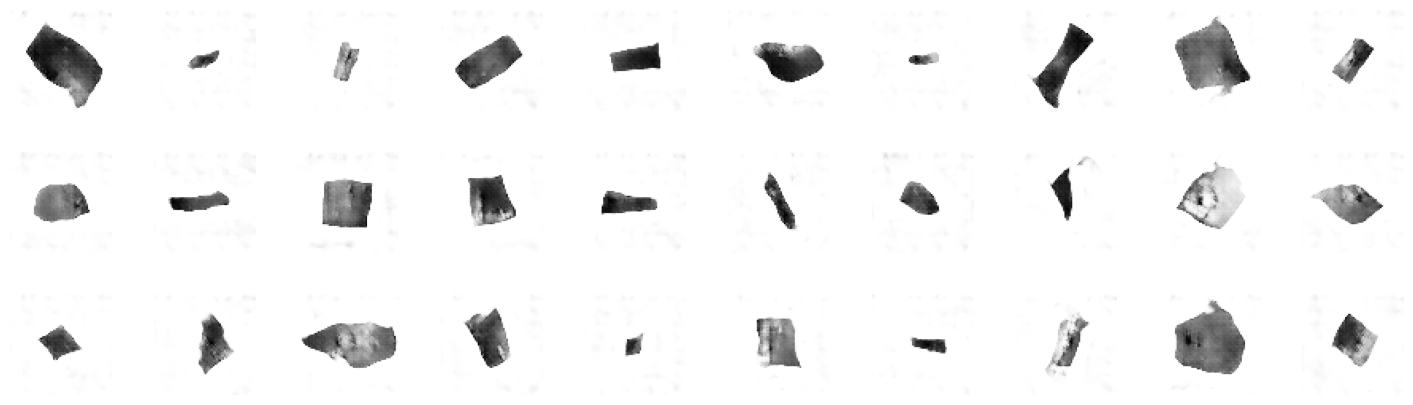

In [37]:
# Sample some points in the latent space, from the standard normal distribution
grid_width, grid_height = (10, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, Z_DIM))

# Decode the sampled points
reconstructions = generator.predict(z_sample)

# Draw a plot of decoded images
fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Output the grid of faces
for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

We also want to make sure a generative model doesn't simply recreate images that are already in the training set. 

As a sanity check, we plot some generated images and the closest training images (using the L1 distance).
This confirms that the generator is able to understand high-level features, even though we didn't provide anything other than raw pixels, and it can generate examples distinct from those encountered before.

1/1 [==============================] - 0s 80ms/step


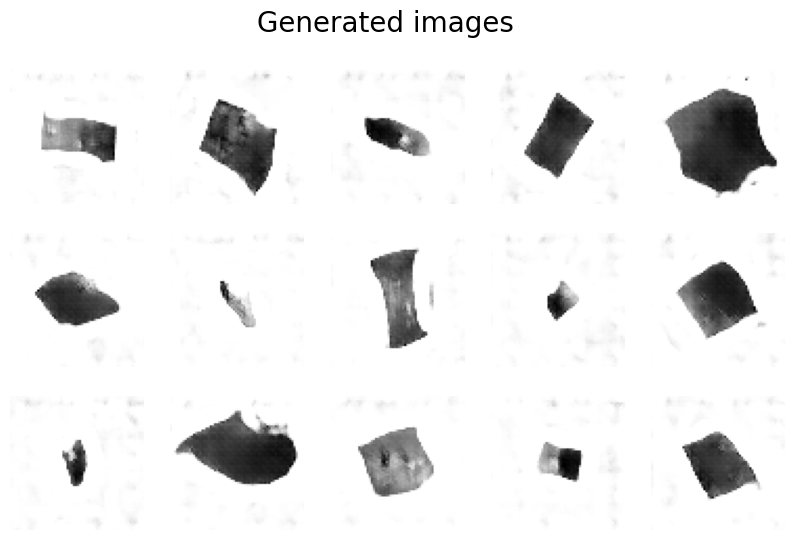

In [40]:
def compare_images(img1, img2):
    return np.mean(np.abs(img1 - img2))

all_data = []
for i in train.as_numpy_iterator():
    all_data.extend(i)
all_data = np.array(all_data)

# Plot the images
r, c = 3, 5
fig, axs = plt.subplots(r, c, figsize=(10, 6))
fig.suptitle("Generated images", fontsize=20)

noise = np.random.normal(size=(r * c, Z_DIM))
gen_imgs = generator.predict(noise)

cnt = 0
for i in range(r):
    for j in range(c):
        axs[i, j].imshow(gen_imgs[cnt], cmap="gray_r")
        axs[i, j].axis("off")
        cnt += 1

plt.show()

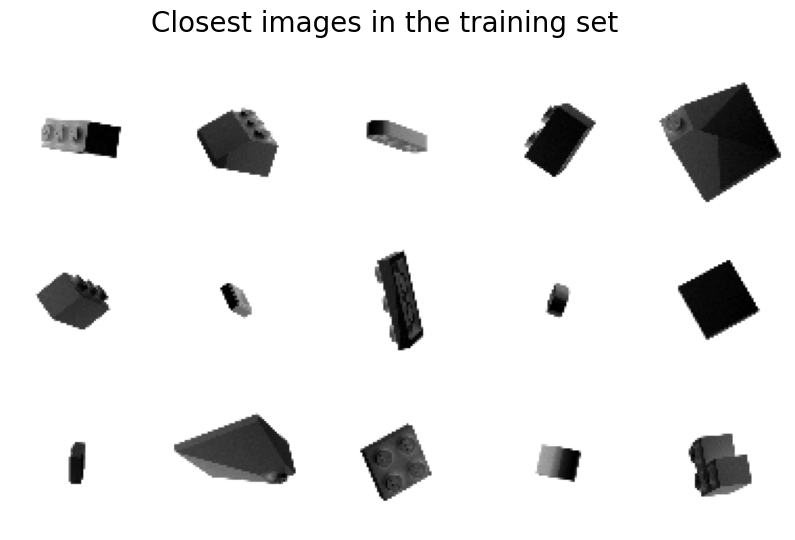

In [41]:
fig, axs = plt.subplots(r, c, figsize=(10, 6))
fig.suptitle("Closest images in the training set", fontsize=20)

cnt = 0
for i in range(r):
    for j in range(c):
        c_diff = 99999
        c_img = None
        for k_idx, k in enumerate(all_data):
            diff = compare_images(gen_imgs[cnt], k)
            if diff < c_diff:
                c_img = np.copy(k)
                c_diff = diff
        axs[i, j].imshow(c_img, cmap="gray_r")
        axs[i, j].axis("off")
        cnt += 1

plt.show()

## 4. GAN Training Tips

GANs are notoriously difficult to train because there is a balancing act between the generator and discriminator; neither should grow so strong that it overpowers the other.

### 4.1. Discriminator Overpowers Generator

The discriminator can always spot the fakes, so the signal from the loss function becomes too weak to cause any meaningful improvements in the generator.

In the extreme case, the discriminator distinguishes fakes perfectly, so gradients vanish and no training takes place.

We need to weaken the discriminator in this case. Some possible options are:

- More dropout
- Lower learning rate
- Simplify the discriminator architecture - use fewer layers
- Add noise to the labels when training the discriminator
- Add intentional labelling errors - randomly flip the labels of some images when training the discriminator


### 4.2. Generator Overpowers Discriminator

If the discriminator is too weak, the generator will learn that it can trick the discriminator using a small sample of nearly identical images. This is known as **mode collapse**. The generator would map every point in the latent space to this image, so the gradients of the loss function would vanish and it would not be able to recover.

Strengthening the discriminator would not help because the generator would just learn to find a different mode that fools the discriminator with no diversity; it is numb to its input.

Some possible options are:

- Strengthen the discriminator - do the opposite of the previous section
- Reduce the learning rate of both generator and discriminator
- Increase the batch size


## 4.3. Uninformative Loss

The value of the loss is not meaningful as a measure of the generator's strength when training.

The loss function is *relative to the discriminator*, and since the discriminator is also being trained, the goalposts are constantly shifting. Also, we don't want the loss function to reach 0 or else we may reach mode collapse as described above.

This makes GAN training difficult to monitor.


## 4.4 Hyperparameters

There are a lot of hyperparameters involved with GANs because we are now training two networks.

The performance is highly sensitive to these hyperparameter choices, and involves a lot of trial and error.

## 5. Wasserstein GAN with Gradient Penalty (WGAN-GP)

The Wasserstein GAN replaces the binary crossentropy loss function with the Wassserstein lss function in both the discriminator and generator.

This results in two desirable properties:

1. A meaningful loss metric that correlates with generator convergence. This allows for better monitoring of training.
2. More stable optimisation process.

### 5.1. Wassertein Loss

#### Revisiting Binary Cross-Entropy Loss
First, recall the **binary cross-entropy loss**, which is defined as:
$$
-\frac{1}{n} \sum_{i=1}^{n}{y_i log(p_i) + (1 - y_i)log(1-p_i)}
$$


In a regular GAN, the discriminator compares the predictions for real images $p_i = D(x_i)$ to the response $y_i = 1$, and it compares the predictions for generated images $p_i = D(G(z_i))$ to the response $y_i = 0$.

So the discriminator loss minimisation can be written as:
$$
\min_{D} -(E_{x \sim p_X}[log D(x)] + E_{z \sim p_Z}[log (1 - D(G(z))] )
$$

The generator aims to trick the discriminator into believing the images are real, so it compares the discriminator's predicted response to the desired response of $y_i=1$.
So the generator loss minimisation can be written as:
$$
\min_{G} -(E_{z \sim p_Z}[log D(G(z)] )
$$


#### Introducing Wasserstein Loss
In contrast , the **Wasserstein loss function** is defined as:
$$
-\frac{1}{n} \sum_{i=1}^{n}{y_i p_i}
$$

It requires that we use $y_i=1$ and $y_i=-1$ as labels rather than 1 and 0. We also remove the final sigmoid activation layer, which constrained the output to the range $[0, 1]$, meaning the output can now be any real number in the range $(-\infty, \infty)$.

Because of these changes, rather than referring to a *discriminator* which outputs a *probability*, for WGANs we refer to a *critic* which outputs a *score*.

With these changes of labels to -1 and 1, the critic loss minimisation becomes:
$$
\min_{D} -(E_{x \sim p_X}[D(x)] - E_{z \sim p_Z}[D(G(z)] )
$$

i.e. it aims to maximise the difference in predictions between real and generated images.

The generator is still trying to trick the critic as in a regular GAN, so it wants the critic to score its generated images as highly as possible. To this end, it still compares to the desired critic response of $y_i=1$ corresponding to the critic believing the generated image is real. So the generator loss minimisation remains similar, just without the log:
$$
\min_{G} -(E_{z \sim p_Z}[D(G(z)] )
$$


### 5.2. Lipschitz Constraint

Allowing the critic to use the range $(-\infty, \infty)$ initially seems a bit counterintuitive - usually we want to avoid large numbers in neural networks otherwise gradients explode!

There is an additional constraint placed on the critic requiring it to be a *1-Lipschitz continuous function*. This means that for any two input images, $x_1$ and $x_2$, it satisfied the following inequality:
$$
\frac{| D(x_1) - D(x_2) |}{| x_1 - x_2 |} \le 1
$$

Recall that the critic is a function $D$ which converts an image into a scalar prediction. The numerator is the change in predictions, and the denominator is the average pixelwise difference. So this is essentially a limit on how sharply the critic predictions are allowed to change for a given image perturbation.

An in-depth exploration of why the Wasserstein loss requires this constraint is given [here](https://jonathan-hui.medium.com/gan-wasserstein-gan-wgan-gp-6a1a2aa1b490).


#### Enforcing the Lipschitz Constraint

One crude way of enforcing the constraint suggested by the original authors (and described as "a terrible way to enforce a Lipschitz constraint) is to clip the weights to $[-0.01, 0.01]$ after each training batch. However, this diminishes the critic's ability to learn.

An improved approach is to introduce a gradient penalty term to penalise the gradient norm when it deviates from 1.


### 5.3. Gradient Penalty Loss


### 5.4. Training the WGAN-GP

When training WGANs, we train the critic to convergence and then the train the generator. This ensures the gradients used for the generator update are accurate.

This is a major benefit over traditional GANs, where we must balance the alternating training of generator and discriminator.

We train the critic several times between each generator training step. A typical ratio is 3-5 critic updates for each generator update.

Note that **batch normalisation shouldn't be used for WGAN-GP** because it creates correlation between images of a given batch, which makes the GP term less effective.


### 5.5. Analysing the WGAN-GP

Images produced by VAEs tend to produce softer images that blur colour boundaries, whereas GANs produce sharper, more well-defined.

However, GANs typically take longer to train and can be more sensitive to hyperparameter choices to reach a satisfactory result.


## 6. Conditional GAN (CGAN)

Conditional GANs allow us to control the *type* of image that is generated. For example, should we generate a large or small brick? A male or female face?


### 6.1. CGAN Architecture

The key difference of a CGAN is we pass a one-hot encoded label.

For the generator, we append the one-hot encoded label vector to the random noise input to the generator.
For the critic, we append the one-hot encoded label vector to the image. If it has multiple channels, as in an RGB image, the label vector is repeated on each of the channels to fit the required shape.


## References

- Chapter 4 of Generative Deep Learning by David Foster.
- [Wasserstein loss and Lipschitz constraint](https://jonathan-hui.medium.com/gan-wasserstein-gan-wgan-gp-6a1a2aa1b490)